In [2]:
import itertools
import pandas as pd
import numpy as np
from tqdm import tqdm  # Progress tracking
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier

In [15]:
df = pd.read_csv('/home/duyle/Rice_photos/features_extracted/moments/bc_15_randomsearchcv.csv')

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', None):
    display(df.sort_values(by='Accuracy', ascending=False))

In [18]:
datasets = ['BC-15','Huongthom', 'Nep87','Q5','Thien_uu','Xi23']

In [19]:
df = pd.read_csv('/home/duyle/Rice_photos/features_extracted/moments/testnewcontour.csv')

In [20]:
basic_features = ["area", "length", "width", "ratio", "major_axis_length", "minor_axis_length", "convex_hull_area",
                  "convex_hull_perimeter","mean_r","mean_g","mean_b","red_sqr","green_sqr","blue_sqr","texture_mean",
                  "texture_std","texture_uniformity","texture_third_moment"]
enhanced_color_features = ['mean_h','mean_s','mean_v','std_h','std_s','std_v','hue_sqr','sat_sqr',
'val_sqr','mean_y','mean_cr','mean_cb','std_y','std_cr','std_cb','y_sqr','cr_sqr','cb_sqr',
'mean_l','mean_a','mean_b','std_l','std_a','std_b_lab','l_sqr','a_sqr','b_lab_sqr']

zernike_features = [col for col in df.columns if col.startswith("zernike_")]
color_features = [col for col in df.columns if col.startswith("csd_")]
lbp_features = [col for col in df.columns if col.startswith("LBP_")]
glcm_features = [col for col in df.columns if col.startswith("GLCM_")]
gist_features = [col for col in df.columns if col.startswith("GIST_")]
edge_features = [col for col in df.columns if col.startswith("edge_energy")]

In [21]:
feature_groups = {
    "Basic": basic_features,
    "Enhanced Color": enhanced_color_features,
    "Zernike moments": zernike_features,
    "LBP": lbp_features,
    "GLCM": glcm_features,
    # "GIST": gist_features,
    "Edge":edge_features
}

In [23]:
feature_combinations = []
for r in range(3, len(feature_groups) + 1):  # From 1 feature group up to all
    for combo in combinations(feature_groups.keys(), r):
        feature_combinations.append(combo)

In [24]:
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=31),
    "Support Vector Machine": SVC(kernel='rbf', C=7.742636826811277,gamma = 'auto'),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True)
}

In [28]:
all_results = []

In [29]:
for data in datasets:
    df=pd.read_csv(f'/home/duyle/Rice_photos/features_extracted/moments/all_with_zernike_pluscolor_enahnced_edge_{data}.csv')
    for feature_combo in feature_combinations:
        selected_features = []
        
        # Combine selected feature groups
        for group in feature_combo:
            selected_features.extend(feature_groups[group])

        # Ensure 'Label' column is included
        df_selected = df[selected_features + ["Label"]]

        X = df_selected.drop(columns=['Label'])
        y = df_selected['Label']

        # Normalize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42, stratify=y)


        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

            all_results.append({
                "Model": name,
                "Dataset": data,
                "Feature Combination": "+".join(feature_combo),
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "CV_scores(5fold)": np.mean(cv_scores)
            })

In [30]:
all_results_df = pd.DataFrame(all_results)

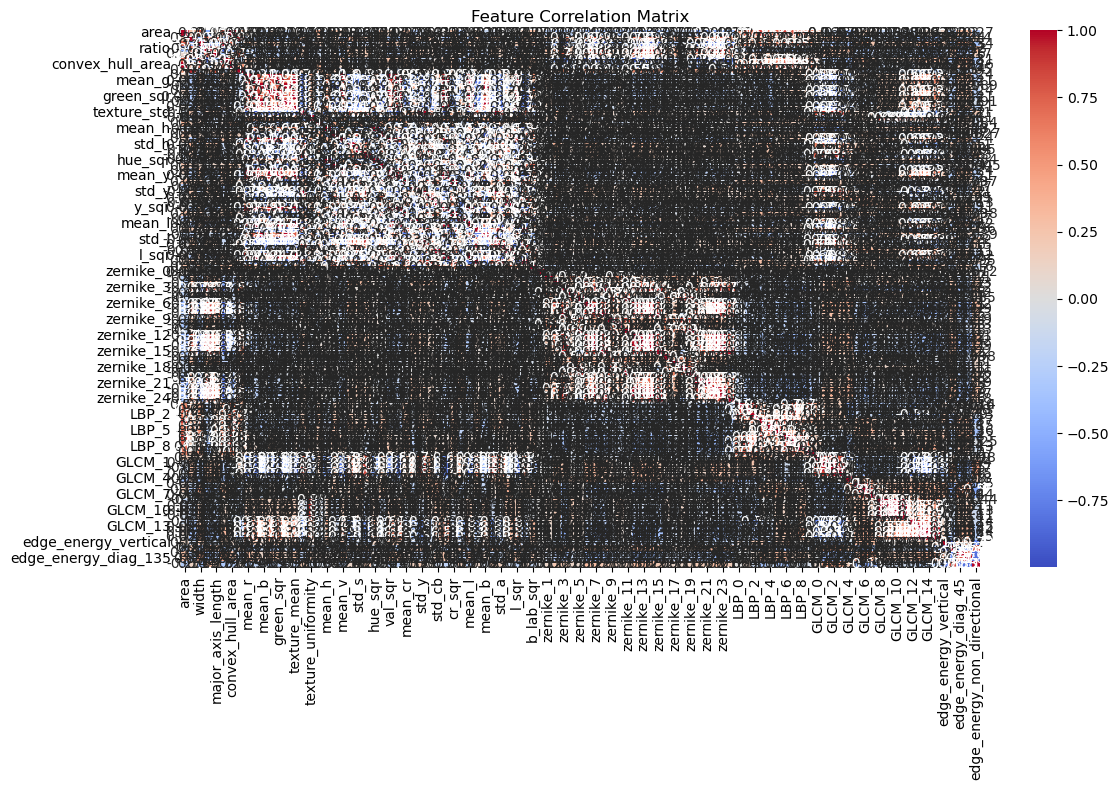


Highly correlated feature pairs (>0.8):
area -- convex_hull_area: 0.993
area -- LBP_3: 0.861
area -- LBP_6: 0.862
length -- major_axis_length: 0.852
length -- convex_hull_perimeter: 0.942
width -- ratio: -0.906
width -- minor_axis_length: 0.956
width -- zernike_6: -0.815
width -- zernike_7: -0.835
width -- zernike_8: -0.814
width -- zernike_12: -0.897
width -- zernike_13: -0.874
width -- zernike_14: -0.878
width -- zernike_15: -0.808
width -- zernike_22: -0.886
width -- zernike_23: -0.883
ratio -- minor_axis_length: -0.841
ratio -- zernike_3: 0.817
ratio -- zernike_6: 0.822
ratio -- zernike_7: 0.881
ratio -- zernike_8: 0.840
ratio -- zernike_12: 0.932
ratio -- zernike_13: 0.914
ratio -- zernike_14: 0.919
ratio -- zernike_15: 0.834
ratio -- zernike_20: 0.815
ratio -- zernike_22: 0.927
ratio -- zernike_23: 0.923
minor_axis_length -- zernike_6: -0.842
minor_axis_length -- zernike_12: -0.892
minor_axis_length -- zernike_13: -0.863
minor_axis_length -- zernike_14: -0.857
minor_axis_length 

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

    # 1. Correlation Matrix with Heatmap
def plot_correlation_matrix(X):
    plt.figure(figsize=(12, 8))
    correlation_matrix = X.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Return highly correlated feature pairs (correlation > 0.8)
    high_corr = np.where(np.abs(correlation_matrix) > 0.8)
    high_corr = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
                 for x, y in zip(*high_corr) if x != y and x < y]
    return high_corr

# 2. VIF (Variance Inflation Factor)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

# Using your existing X dataframe (features only, no target variable)
X = df_selected.drop(columns=['Label'])

# 1. Check correlation matrix
high_correlations = plot_correlation_matrix(X)
print("\nHighly correlated feature pairs (>0.8):")
for feat1, feat2, corr in high_correlations:
    print(f"{feat1} -- {feat2}: {corr:.3f}")

# 2. Check VIF scores
vif_scores = calculate_vif(X)
print("\nVIF Scores (>5 may indicate multicollinearity):")
print(vif_scores)